In [17]:
# import libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math

In [18]:
# data frame creation
folder_path = 'data/20250813/'  # update this with the folder path
file_names = [f for f in os.listdir(folder_path)] # creates list of file names in folder_path as str type

df_list = [
    pd.read_excel(os.path.join(folder_path, f))
    for f in sorted(os.listdir(folder_path))
    if f.endswith('.xlsx')
    ] # creates dataframe as a list from each of the files
df = pd.concat(df_list, ignore_index=True) # joins the dataframe list to create one dataframe of values

In [19]:
# dataframe cleaning

# changes timestamp str values to datetime objects
df["Timestamp"] = pd.to_datetime(df["Timestamp"]) 
# creates column of the day of the week as a str type
df["day_of_week_str"] = [date.strftime("%A") for date in df["Timestamp"]] 
# creates column of the day of the week as a int type (Monday=0, ..., Sunday=6); used to make graphing easier
df["day_of_week_num"] = [date.weekday() for date in df["Timestamp"]] 
# creates row for ZEM value as int type
df["zem"] = [v[:6] for v in df["Sensor Name"]] 
# creates row for second sensor value as str
df["second_sensor"] = [v[9:] for v in df["Sensor Name"]]
# make Reading value into kW
df["Reading"] = df["Reading"]/1000

In [ ]:
def print_difference_sensor_readings(df_filtered: pd.DataFrame, start_time: str, end_time: str):
    """
    df_filtered (pd.DataFrame): filtered data containing values of sensor data from within 
                                start_time and end_time 
    start_time (str): Start of time interval
    end_time (str): End of time interval

    Prints the change in sensor readings for each (zem, second_sensor) pair between the times 
    closest to start_time and end_time. Locates the reading closest to start_time and end_time 
    and then calculates and prints the difference by 10 decimal points. 
    """
    # define variables
    start_time_dt = pd.to_datetime(start_time)
    end_time_dt = pd.to_datetime(end_time)

    print("-" * 50)
    print("Change in Sensor Readings:")
    print("-" * 50)
    
    # Group by both ZEM and second_sensor to handle all sensors correctly
    for (zem_value, second_sensor), group in df_filtered.groupby(['zem', 'second_sensor']):

        # Find the reading at or closest to the start time
        start_reading_row = group.loc[(group['Timestamp'] - start_time_dt).abs().idxmin()]
        start_reading = start_reading_row['Reading']

        # Find the reading at or closest to the end time
        end_reading_row = group.loc[(group['Timestamp'] - end_time_dt).abs().idxmin()]
        end_reading = end_reading_row['Reading']
        
        # Calculate the change
        change = end_reading - start_reading
        
        print(f"ZEM: {zem_value}, Sensor: {second_sensor} | Change: {change:.10f}")
    
    print("-" * 50)

    return

def plot_sensor_readings(df: pd.DataFrame, start_time: str, end_time: str, start_buffer=5, end_buffer=5):
    """
    df (pd.DataFrame): DataFrame with columns
        ['Site', 'Sensor Name', 'Timestamp', 'Reading',
        'day_of_week_str', 'week_day', 'day_of_week_num',
        'zem', 'second_sensor']
    start_time (str): Start of time interval
    end_time (str): End of time interval
    start_buffer (int): how many minutes from start_time to plot
    end_buffer (int): how many minutes after end_time to plot

    Plots sensor readings for each unique (zem, second_sensor) pair within a specified time interval. 
    Creates a separate figure for each 'zem' value, with subplots arranged 2 per row. Adds vertical 
    red lines at the specified start and end times.
    """
    # define variables 
    start_time_dt = pd.to_datetime(start_time)
    end_time_dt = pd.to_datetime(end_time)
    lower_interval = start_time_dt - pd.to_timedelta(start_buffer, unit='minutes')
    upper_interval = end_time_dt + pd.to_timedelta(end_buffer, unit='minutes')

    # Filter data by time interval, including buffer
    mask = (df['Timestamp'] >= lower_interval) & (df['Timestamp'] <= upper_interval)
    df_filtered = df.loc[mask].copy()
    
    # print sensor differences from start and end time
    print_difference_sensor_readings(df_filtered, start_time, end_time)

    # Loop over each ZEM sensor first
    for zem_value, zem_df in df_filtered.groupby('zem'):
        grouped = list(zem_df.groupby('second_sensor')) # group rows by second sensor value
        n_plots = len(grouped) 
        n_cols = 2
        n_rows = math.ceil(n_plots / n_cols)

        # create plots
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows), sharex=False)
        fig.suptitle(f"kW for {zem_value} from {start_time} to {end_time}", fontsize=16)
        axes = axes.flatten() if n_plots > 1 else [axes]

        for i, (second_sensor, group) in enumerate(grouped): # creates individual plots
            ax = axes[i]
            group = group.sort_values(by="Timestamp")
            ax.plot(group['Timestamp'], group['Reading'], marker='o', linestyle='-')
            ax.set_title(f"{zem_value}:{second_sensor}")
            ax.set_xlabel("Timestamp")
            ax.set_ylabel("Reading (kW)")
            ax.tick_params(axis='x', rotation=45) # rotate x axis timestamp values by 45 degrees
            ax.grid(True)

            # Add vertical lines at the specified start and end times
            ax.axvline(x=start_time_dt, color='red', linestyle='--', label='Start Time')
            ax.axvline(x=end_time_dt, color='red', linestyle='--', label='End Time')
            ax.legend()

        # Hide any unused axes
        for j in range(i+1, len(axes)):
            fig.delaxes(axes[j])
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for suptitle
        plt.show()

    return

--------------------------------------------------
Change in Sensor Readings:
--------------------------------------------------
ZEM: ZEM001, Sensor: CT01 | Change: 0.0000100000
ZEM: ZEM001, Sensor: CT02 | Change: 0.0000100000
ZEM: ZEM001, Sensor: CT03 | Change: 0.0000100000
ZEM: ZEM002, Sensor: CT01 | Change: 0.0000000000
ZEM: ZEM002, Sensor: CT02 | Change: 0.0000000000
ZEM: ZEM002, Sensor: CT03 | Change: 0.0000000000
ZEM: ZEM003, Sensor: CT01 | Change: 0.0000000000
ZEM: ZEM003, Sensor: CT02 | Change: 0.0000100000
ZEM: ZEM003, Sensor: CT03 | Change: 0.0000000000
--------------------------------------------------


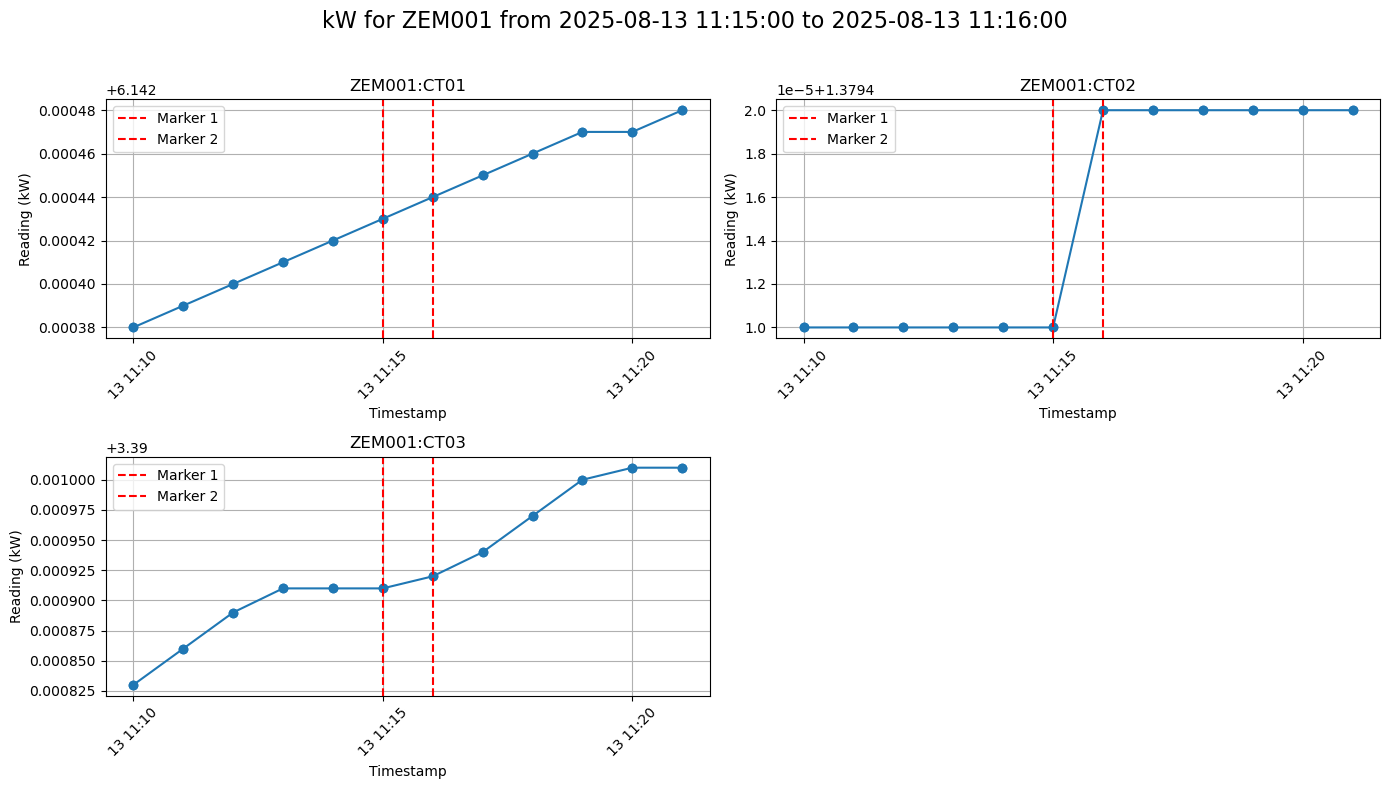

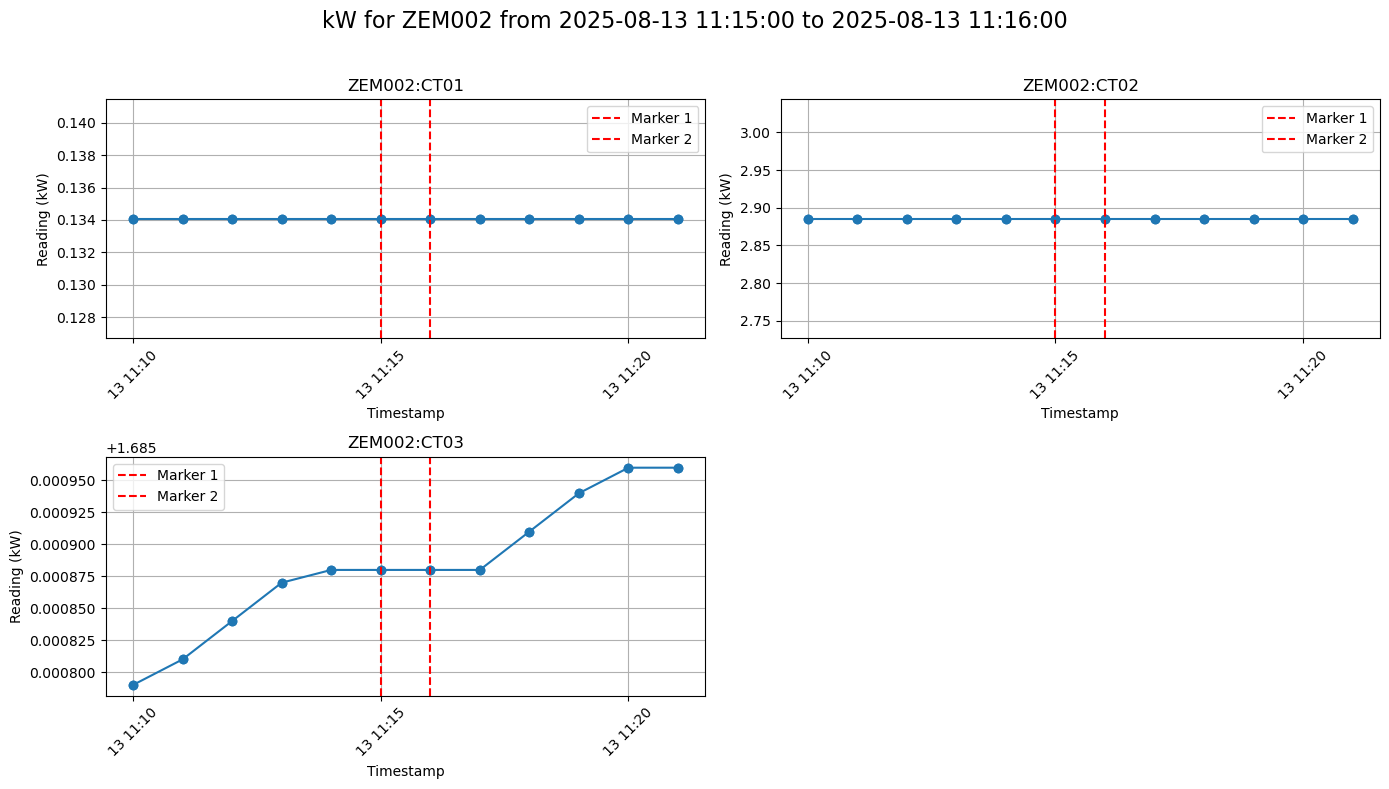

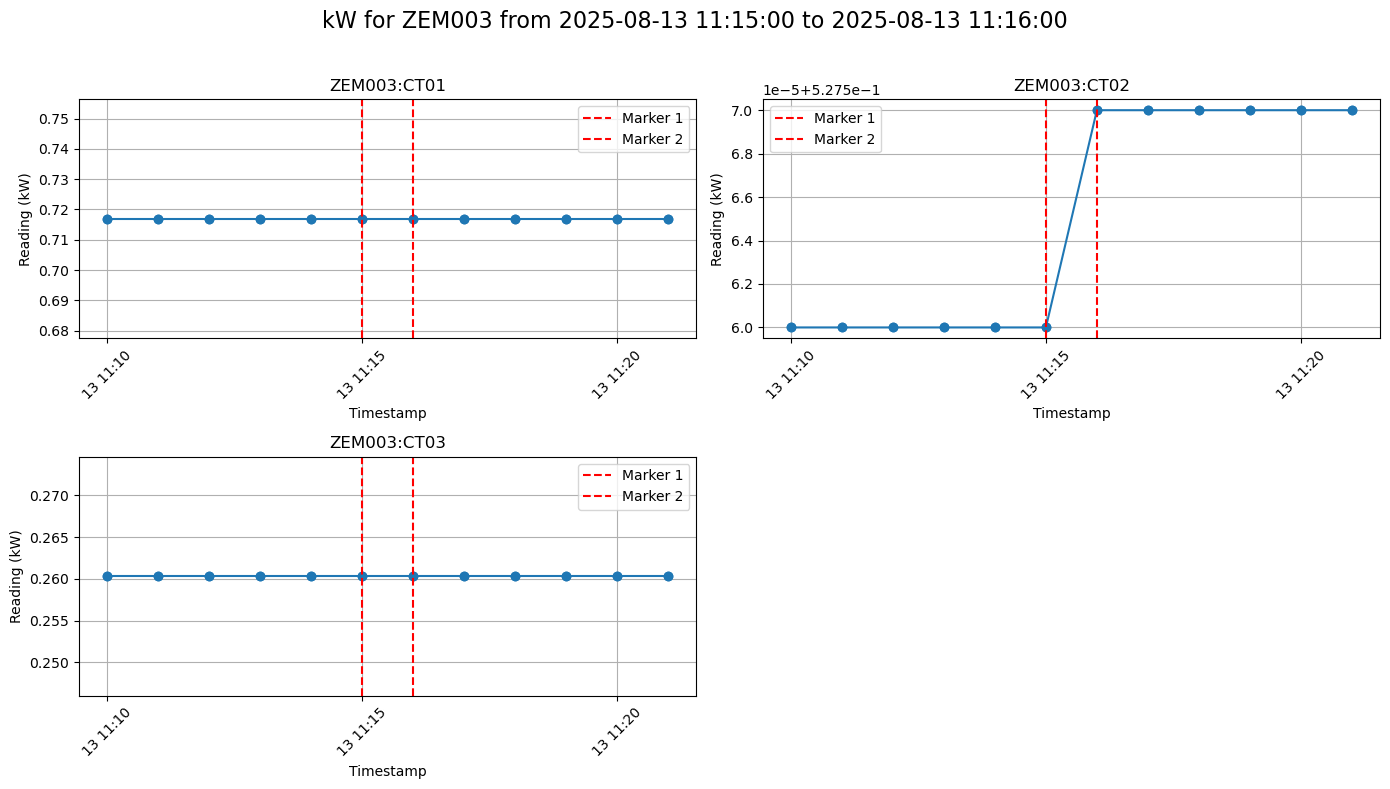

In [ ]:
plot_sensor_readings(df, "2025-08-13 11:15:00", "2025-08-13 11:16:00")